In [1]:
import pandas as pd
import numpy as np
import os

# Drawing
import cartopy
import matplotlib
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.io import shapereader
from matplotlib.cm import get_cmap
import matplotlib.cm as cm
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Gifs
import imageio

## Map

In [2]:
def make_map(council_dict, title, scale_max, filepath):
    fig = plt.figure(figsize=(6,8), dpi=100)
    projectionPARAM = ccrs.TransverseMercator(central_longitude=-2.0, central_latitude=49.0, false_easting=400000.0, false_northing=-100000.0, scale_factor=0.9996012717, approx=False)
    ax = fig.add_subplot(1, 1, 1, projection=projectionPARAM)
    ax.set_extent([-10.75, 2, 49.75, 61])

    # Downloaded from: https://geoportal.statistics.gov.uk/datasets/ons::local-authority-districts-may-2021-uk-bfe-1/about
    area_file = os.path.join(os.getcwd(), 'shapefiles', 'Local_Authority_Districts_May_2021_UK_BFE', 'LAD_MAY_2021_UK_BFE_V2.shp')
    council_divisions = shapereader.Reader(area_file)

    norm = colors.Normalize(vmin=0., vmax=scale_max)
    cmap = matplotlib.colormaps['plasma'] # PuBu
    
    # Counter for council_entries used
    council_entry_used = 0
    used_councils = []

    for record in council_divisions.records():
        code = record.attributes['LAD21NM']
        council_entry = council_dict.get(code, -1)
        if council_entry == -1:
            council_color = "Silver"
        else:
            council_color = cmap(council_entry/max(council_dict.values()))
            council_entry_used += 1
            used_councils.append(code)
        
        ax.add_geometries(
                [record.geometry],
                #facecolor=numpy.random.rand(3,),
                facecolor=council_color,
                linewidth=0,
                crs=projectionPARAM,
        )

    divider = make_axes_locatable(ax)
    ax_cb = divider.new_horizontal(size="5%", pad=0.1, axes_class=plt.Axes)

    fig.add_axes(ax_cb)

    sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
    cb = plt.colorbar(sm, cax=ax_cb)
    cb.set_label("Number of employees in reciept of over £100,000 Total Renumeration")

    fig.suptitle(title, fontsize=16)
    
    # Print statistics
#     print("We used " + str(round((council_entry_used/len(council_dict))*100, 2)) + "% of the council_entries")
#     print("This was " + str(len(council_dict) - council_entry_used) + " councils that we couldn't match to the Shapefile")
    
    # Create unused councils
    unused_councils = list(set(council_dict.keys()) - set(used_councils))
    
    plt.tight_layout()
    plt.savefig(filepath)
    plt.close()
    
    return unused_councils

In [3]:
# data_df = pd.read_pickle("pickles/2021_22.pkl")
# council_dict = (data_df[['Council', 'count_people']].set_index('Council').T.to_dict('records'))[0]

# unused_councils = make_map(council_dict, "Town Hall Rich List 2023", max(data_df["count_people"]), "results/thrl_2023.png")

## Animated Map

In [4]:
def create_pickle_path(year):
    start_year = 2000
    return str(start_year + year) + "_" + str(year + 1)

def create_council_dict_from_pickle_path(pickle_path):
    data_df = pd.read_pickle("pickles/" + str(pickle_path) + ".pkl")
    council_dict = (data_df[['Council', 'count_people']].set_index('Council').T.to_dict('records'))[0]
    return council_dict

Creating Max for the scale
Max determined on scale is: 68
Creating charts

This pickle path is: 2011_12
Doing Frame: 0
Doing Frame: 1
Doing Frame: 2
Doing Frame: 3
Completed: 2021_22
This pickle path is: 2012_13
Doing Frame: 0
Doing Frame: 1
Doing Frame: 2
Doing Frame: 3
Completed: 2021_22
This pickle path is: 2013_14
Doing Frame: 0
Doing Frame: 1
Doing Frame: 2
Doing Frame: 3
Completed: 2021_22
This pickle path is: 2014_15
Doing Frame: 0
Doing Frame: 1
Doing Frame: 2


KeyboardInterrupt: 

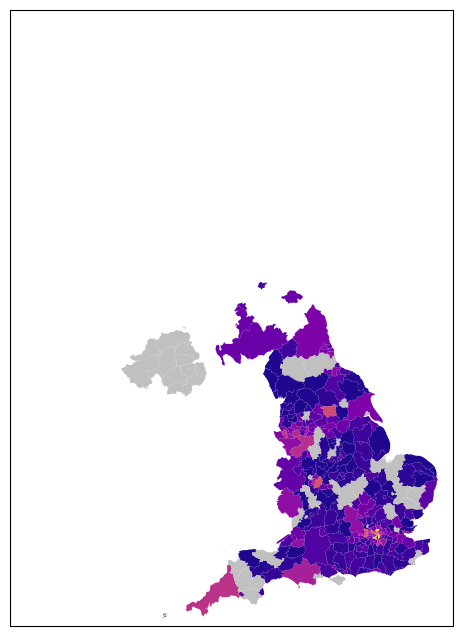

In [9]:
# TODO: Make version that fades between years!
n_frames = 3
start_year = 2000

print("Creating Max for the scale")
# Create MAX for scale
current_max = -1
for i in range(11, 22):
    pickle_path = str(start_year+i) + "_" + str(i+1)
    data_df = pd.read_pickle("pickles/" + str(pickle_path) + ".pkl")
    
    this_max = max(data_df["count_people"])
    
    # Replace if bigger
    if current_max < this_max:
        current_max = this_max

print("Max determined on scale is: " + str(current_max))
# Create charts
print('Creating charts\n')
filenames = []
all_unused_councils = []
year_list = list(range(11, 22))
for index in np.arange(0, len(year_list)-1):
    start_year = year_list[index]
    next_year = year_list[index + 1]
    
    current_pickle_path = create_pickle_path(start_year)
    print("This pickle path is: " + str(current_pickle_path))
    next_pickle_path = create_pickle_path(next_year)
    
    current_council_dict = create_council_dict_from_pickle_path(current_pickle_path)
    next_council_dict = create_council_dict_from_pickle_path(next_pickle_path)
    
    # calculate the distance to the next position
    #council_dict_path = next_council_dict - current_council_dict
    transition_council_dict = {key: next_council_dict[key] - current_council_dict.get(key, 0) for key in next_council_dict}
    
    # Make different steps of images
    for i in np.arange(0, n_frames + 1):
        print("Doing Frame: " + str(i))
        # divide the distance by the number of frames 
        # and multiply it by the current frame number
        count_dict_temp = {k: (v + (transition_council_dict.get(k, 0) / n_frames) * i)  for k, v in current_council_dict.items()}
        
        # create filename
        filename = f'temporary_images/frame_{index}_{i}.png'
        
        # first frame of each viz stays longer
        if (i == 0):
            unused_councils = make_map(current_council_dict, pickle_path.replace("_", " - "), current_max, filename)
            
            for i in range(5):
                filenames.append(filename)
        else:
            unused_councils = make_map(count_dict_temp, " ", current_max, filename)
            # build file name and append to list of file names
            filenames.append(filename)
    
    all_unused_councils.append(unused_councils)
    
    print("Completed: " + str(current_pickle_path))

print('Charts saved\n')
# Build GIF
print('Creating gif\n')
with imageio.get_writer('results/static_version.gif', mode='I') as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
print('Gif saved\n')
print('Removing Images\n')
# Remove files
for filename in set(filenames):
    os.remove(filename)
print('DONE')

In [ ]:
# Create list of available councils
# Downloaded from: https://geoportal.statistics.gov.uk/datasets/ons::local-authority-districts-may-2021-uk-bfe-1/about
area_file = os.path.join(os.getcwd(), 'shapefiles', 'Local_Authority_Districts_May_2021_UK_BFE', 'LAD_MAY_2021_UK_BFE_V2.shp')
council_divisions = shapereader.Reader(area_file)

available_councils = []

for record in council_divisions.records():
    code = record.attributes['LAD21NM']
    available_councils.append(code)

In [ ]:
available_councils.sort()
available_councils

In [ ]:
all_unused_councils[-1].sort()
all_unused_councils[-1]